In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import pickle

In [2]:
def init_filter(f, n_C_prev, n_C):
    """
    对内核进行初始化
    """
    w = np.random.randn(f,f,n_C_prev, n_C) * 0.01
    b = np.random.randn(1, 1, 1, n_C) * 0.01
    
    return w , b

In [3]:
def zero_pad(X, pad):
    """
    在输入层周围加PAD来维持CNN的大小。
    
    参数:
    X -- numpy array 形状 (m, n_H, n_W, n_C) 代表了 m 张图片
    pad -- 想要加在长和宽上的PAD
    
    返回:
    X_pad -- 返回加号PAD的一组图片，大小为 (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    
    return X_pad

In [4]:
def conv_single_step(a_slice_prev, W, b):
    """
    对输入层中的选中的区域与内核进行一次CNN操作，
    参数:
    a_slice_prev -- 输入层中选中的区域，形状为 (f, f, n_C_prev)
    W -- 一片内核的权值，形状为(f, f, n_C_prev)
    b -- 一片内核的BIAS，形状为(1, 1, 1)
    返回:
    Z -- 一个数值
    """
    # 各个对应位置的元素进行想乘
    s = np.multiply(a_slice_prev, W)
    # 将所有元素相加 
    Z = np.sum(s)
    # 加上 bias
    Z = Z + float(b)
    return Z

In [5]:
def conv_forward(A_prev, W, b, hparameters):
    """
    一次完整的CNN
    参数:
    A_prev -- 输入层, 形状为 (m, n_H_prev, n_W_prev, n_C_prev)
    W -- 内核的权值，形状为 (f, f, n_C_prev, n_C)
    b -- 内核的BIAS，形状为 (1, 1, 1, n_C)
    hparameters -- python dictionary 超参数中包含了 "stride" 和 "pad"        
    返回:
    Z -- 一次完整CNN后的输出层，形状为 (m, n_H, n_W, n_C)
    cache -- 将计算过程中的一些值存储起来，反向回归时需要进行使用
    """
    # 获得输入层的形状 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    # 获得内核的形状
    (f, f, n_C_prev, n_C) = W.shape
    # 获得内核进行操作时的步距和加在输入层中PAD的大小
    stride = hparameters['stride']
    pad = hparameters['pad']
    # 先计算出输出层的形状大小
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    # 先建立一个空的输出层，之后逐步计算，将各个位置上的0值进行替换
    Z = np.zeros((m, n_H, n_W, n_C))
    # 在输入层周围增加指定的PAD
    A_prev_pad = zero_pad(A_prev, pad)
    for i in range(m):                               # 对每一个训练样本进行分别的操作
        a_prev_pad = A_prev_pad[i]                   # 选中第i个训练样本的输入值
        for h in range(n_H):                # 轮询这个训练样本中的空的输出层中的每一个位置，然后求这里应该置放的数值
            for w in range(n_W):                       
                for c in range(n_C):                          
                    # 寻找输出层这个位置对应的输入层中的位置
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    # 将对应的输入层的这一区域选择出来
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # 指定区域中的一次CNN操作
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
    # 将在回归中使用的数据临时存放在CACHE中
    cache = (A_prev, W, b, hparameters)
    return Z, cache

In [6]:
def linear_forward(A, W, b):
    """
    全连层神经网络中的 W * A + b

    """

    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    全连层神经网络中 sigmoid(W*A+b)

    """
    
    if activation == "sigmoid":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [8]:
def initialize_parameters_deep(layer_dims):
    """
    全连层中的权值 W和b 的初始化
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # 前后的大小

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [9]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    CNN中池化层的前向传播
    

    """
    
    # 获取输入层的大小
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 获得步数和内核的大小
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # 确定输出层的形状大小
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # 先建立一个空的输出层，随后分别填入
    A = np.zeros((m, n_H, n_W, n_C))              
    
    #轮询输出层中的每一个位置，然后算出其所应该输出的值
    for i in range(m):                         
        for h in range(n_H):                     
            for w in range(n_W):                 
                for c in range (n_C):            
                    
                    # 找到与输出层对应位置的输入层的区域
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # 选出这片输入区域
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # 得出结果
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    
   
    cache = (A_prev, hparameters)
    
    return A, cache

In [10]:
def conv_backward(dZ, cache):
    """
    CNN 的反向传导，对权值，BIAS，以及输入层分别求导 
    参数:
    dZ -- 输出层的导数值, 形状为 (m, n_H, n_W, n_C)
    cache -- 前向传导时 conv_forward() 输出的缓存  
    返回值:
    dA_prev -- 输入层对于COST值的的导数,形状大小为 (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- 权值W先对于COST值的导数形状大小为 (f, f, n_C_prev, n_C)
    db -- 权值BIAS相对于COST值的导数 (b)形状大小为 (1, 1, 1, n_C)
    """
    # 存缓存中获取之前存入的值
    (A_prev, W, b, hparameters) = cache 
    # 获得输入层的形状大小
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape   
    # 获得内核的形状大小
    (f, f, n_C_prev, n_C) = W.shape    
    # 获得之前设定的步距和PAD
    stride = hparameters["stride"]
    pad = hparameters["pad"]    
    # 获得输出层的大小
    (m, n_H, n_W, n_C) = dZ.shape   
    # 先确定大小，然后建空的，之后一个个位置进行更新
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    # 前向传导时的PAD要在此时加上
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)  
    for i in range(m):                       # 循环所有的训练样本  
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]      
        for h in range(n_H):                  
            for w in range(n_W):               
                for c in range(n_C):                               
                    # 找到对应的区域
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f                                     
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    # 算出对应区域的导数
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]                    
        # 去掉PAD
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]     
    return dA_prev, dW, db

In [11]:
def pool_backward(dA, cache, mode = "max"):
    """
    池化层的反向传导
    
    参数:
    dA -- 输出层相对于COST的导数
    cache -- 前向传导中所存储的一些基础信息
    mode -- 通常有两种模式 ("max" or "average")
    
    返回值:
    dA_prev -- 输入层相对于COST的导数
    """
    
    
    # 从之前存储的CACHE中取出输入层和超参
    (A_prev, hparameters) = cache
    
    # 获得步距和POOL的大小
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # 获得输入层的大小和输出层的大小
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # 先建立DA的形状，然后对里面的每一个位置分别更新
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # 循环所有的训练样本
        
        a_prev = A_prev[i]
        for h in range(n_H):                 
            for w in range(n_W):              
                for c in range(n_C):          
                    # 找到对应的位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
    
                    if mode == "max":
                        # 选出这一块区域
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # 建立遮罩
                        mask = create_mask_from_window(a_prev_slice)
                        # 求出此区域对应的值
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                     
                        da = dA[i, h, w, c]
                    
                        shape = (f, f)
                     
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    
    
    return dA_prev

In [12]:
def sigmoid(Z):
    """
    SIGMOID 方法  
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    RELU方法
    """
    
    A = np.maximum(0,Z)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    RELU 反向传播
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) 
    
    # 如果Z<=0则 DZ也应为0
    dZ[Z <= 0] = 0
    
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    SIGMOID 的反向传播方法
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [13]:
def compute_cost(AL, Y):
    """
    计算预测值与正确答案的差距，COST函数

    """
    m = Y.shape[1]

    # AL为预测值，Y为正确答案，本处使用的COST函数为Cross ENTROPY
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    cost = np.squeeze(cost)      
    return cost

In [14]:
def linear_forward(A, W, b):
    """
    传统全连接神经网络的前向传播
    """
    
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache


In [15]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    传统全连接神经网络的前向传导，包括了ACTIVATION函数的部门

    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [16]:
def linear_backward(dZ, cache):
    """
    传统全连接神经网络的反向传播

    """
    A_prev, W, b = cache
    m = A_prev.shape[1]


    dW = np.dot(dZ, cache[0].T) / m
    db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(cache[1].T, dZ)

    
    
    return dA_prev, dW, db

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    传统全连接神经网络的反向传播，包括activation函数在内
    
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)

        
    elif activation == "sigmoid":

        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [18]:
def load_data():
    train_dataset = h5py.File('/Users/shangqunyu/Downloads/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 训练样本的X值
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 训练样本的标签

    test_dataset = h5py.File('/Users/shangqunyu/Downloads/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 测试样本的X值
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 测试样本的标签

    classes = np.array(test_dataset["list_classes"][:]) # 类别种类
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [19]:
def create_mask_from_window(x):
    """
    建立一个遮罩，方法为MAXPOOL使用，来确定究竟是哪一个位置的输入值为COST提供了贡献。
    """
    mask = x == np.max(x)
    
    return mask

In [70]:
def model(X, Y, learning_rate=0.0075, num_iterations=1000,load_parameters=False, print_cost=False):
    grads = {}
    costs = []              
    m = X.shape[0]
    print(m)
    #选择初始化参数或者载入已经训练好的参数
    if load_parameters == True:
        w1,b1,w2,b2,w3,b3 = loadParameter()
    else:        
        w1, b1 = init_filter(4,3,12)
        w2, b2 = init_filter(4,12,48)
        parameters = initialize_parameters_deep([48,1])
        w3 = parameters['W1']
        b3 = parameters['b1']     
    hparameters_filter = {
        "stride":2,
        "pad" : 1
    }
    hparameters_pool = {
        "stride":4,
        "f" : 4
    }
    for i in range(1, num_iterations):
        # 前向传导: CONV -> RELU -> MAXPOOL -> CONV -> RELU -> MAXPOOL -> LINEAR -> SIGMOID
        conv_Out1, cache1 = conv_forward(X, w1, b1, hparameters_filter)
        relu_Out1, cache2 = relu(conv_Out1)
        pool_Out1, cache3 = pool_forward(relu_Out1, hparameters_pool)   
        conv_Out2, cache4 = conv_forward(pool_Out1, w2, b2, hparameters_filter)
        relu_Out2, cache5 = relu(conv_Out2)
        pool_Out2, cache6 = pool_forward(relu_Out2, hparameters_pool)      
        flatten = pool_Out2.reshape(pool_Out2.shape[0], -1).T       
        A, cache7 = linear_activation_forward(flatten,w3,b3,"sigmoid")
        # 计算本次前向传导后的值与正确答案之间的COST
        cost = compute_cost(A, Y)    
        # 反向传播  
        dA = - (np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        dflatten, dw3, db3 = linear_activation_backward(dA, cache7, "sigmoid")
        dpool_Out2 = (dflatten.T).reshape(m,1,1,48)    
        drelu_Out2 = pool_backward(dpool_Out2, cache6, "max")
        dconv_Out2 = relu_backward(drelu_Out2, cache5)     
        dpool_Out1, dw2, db2 = conv_backward(dconv_Out2, cache4)
        drelu_Out1 = pool_backward(dpool_Out1, cache3, "max")
        dconv_Out1 = relu_backward(drelu_Out1, cache2)
        dX, dw1, db1 = conv_backward(dconv_Out1, cache1)     
        #更新参数
        w1 = w1 - learning_rate * dw1
        b1 = b1 - learning_rate * db1
        w2 = w2 - learning_rate * dw2
        b2 = b2 - learning_rate * db2
        w3 = w3 - learning_rate * dw3
        b3 = b3 - learning_rate * db3     
        print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        #每训练10次就存起来，以后直接用，不用再重头进行训练了。
        if i % 5 == 0:
            storeParameter(w1,b1,w2,b2,w3,b3,i)
            print("parameter saved")
    # 画出COST函数的变化趋势
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return w1,b1,w2,b2,w3,b3     

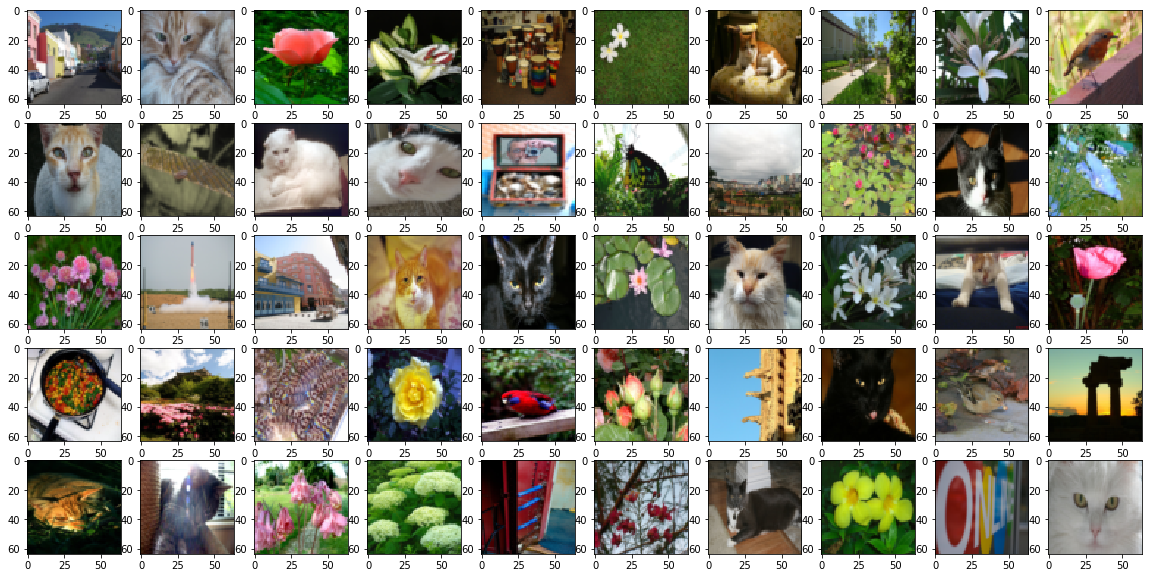

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()


fig=plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_x_orig[i])
plt.show()

train_x = train_x_orig/255
test_x = test_x_orig /255

In [86]:
model(train_x, train_y, num_iterations = 2500, load_parameters=True, print_cost=True)
#开始训练

209
Cost after iteration 1: 0.3845897348807828
Cost after iteration 2: 0.38123273121855206
Cost after iteration 3: 0.377987471247614
Cost after iteration 4: 0.37622885222004676
Cost after iteration 5: 0.37772704197619295
parameter saved
Cost after iteration 6: 0.3975364787909964
Cost after iteration 7: 0.4854973624383399
Cost after iteration 8: 0.4921949280565631
Cost after iteration 9: 0.45665714307734123
Cost after iteration 10: 0.4063866732290398
parameter saved
Cost after iteration 11: 0.39772659678570016
Cost after iteration 12: 0.3904818777829812
Cost after iteration 13: 0.3849199817775204
Cost after iteration 14: 0.38044801767510705
Cost after iteration 15: 0.3764450573830375
parameter saved
Cost after iteration 16: 0.3728279651966827
Cost after iteration 17: 0.3704040294735972
Cost after iteration 18: 0.3686269534607604
Cost after iteration 19: 0.3667564196371275
Cost after iteration 20: 0.36689366876166024
parameter saved
Cost after iteration 21: 0.37168004245137826
Cost after

Cost after iteration 172: 0.35648002986056865
Cost after iteration 173: 0.41412112874537504
Cost after iteration 174: 0.5404885122438038
Cost after iteration 175: 0.413384737448427
parameter saved
Cost after iteration 176: 0.36980593721497623
Cost after iteration 177: 0.35630859120764297
Cost after iteration 178: 0.35089225398081647
Cost after iteration 179: 0.3480107796549504
Cost after iteration 180: 0.35253131204987864
parameter saved
Cost after iteration 181: 0.3727495121673828
Cost after iteration 182: 0.4508411634348096
Cost after iteration 183: 0.40500353365633235
Cost after iteration 184: 0.38805366475546915
Cost after iteration 185: 0.35688549094077043
parameter saved
Cost after iteration 186: 0.3613075034946679
Cost after iteration 187: 0.37866866249102665
Cost after iteration 188: 0.4600769401738221
Cost after iteration 189: 0.38974843301055795
Cost after iteration 190: 0.349223917889007
parameter saved
Cost after iteration 191: 0.3320224706343551
Cost after iteration 192: 0

KeyboardInterrupt: 

In [21]:
def storeParameter(w1,b1,w2,b2,w3,b3,i):
    #存参数
    storedict={
        "w1":w1,
        "b1":b1,
        "w2":w2,
        "b2":b2,
        "w3":w3,
        "b3":b3,
        "NumberOfTraining":i
    }
    with open('parameters.pickle', 'wb') as handle:
        pickle.dump(storedict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [22]:
def loadParameter():
    #取参数
    with open('parameters.pickle', 'rb') as handle:
        parameters = pickle.load(handle)
    w1 = parameters['w1']
    b1 = parameters['b1']
    w2 = parameters['w2']
    b2 = parameters['b2']
    w3 = parameters['w3']
    b3 = parameters['b3']
    return w1,b1,w2,b2,w3,b3

In [24]:
w1,b1,w2,b2,w3,b3 = loadParameter()

In [25]:
def predict(X, y, w1,b1,w2,b2,w3,b3):
    """
    用来测试网络的准确率
    """
    
    m = X.shape[0]
    print(m)
    p = np.zeros((1,m))
    
    hparameters_filter = {
        "stride":2,
        "pad" : 1
    }
    hparameters_pool = {
        "stride":4,
        "f" : 4
    }
    
    # 前向传导
    conv_Out1, cache1 = conv_forward(X, w1, b1, hparameters_filter)
    relu_Out1, cache2 = relu(conv_Out1)
    pool_Out1, cache3 = pool_forward(relu_Out1, hparameters_pool)   
    conv_Out2, cache4 = conv_forward(pool_Out1, w2, b2, hparameters_filter)
    relu_Out2, cache5 = relu(conv_Out2)
    pool_Out2, cache6 = pool_forward(relu_Out2, hparameters_pool)
        
    flatten = pool_Out2.reshape(pool_Out2.shape[0], -1).T
        
    probas, cache7 = linear_activation_forward(flatten,w3,b3,"sigmoid")

    
    # 
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [26]:
prediction = predict(train_x, train_y, w1,b1,w2,b2,w3,b3)

209
Accuracy: 0.8564593301435406


In [27]:
prediction = predict(test_x, test_y, w1,b1,w2,b2,w3,b3)

50
Accuracy: 0.74
